In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
from pylatexenc import *
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import pulse                 
from qiskit.circuit import Parameter, Gate
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.transpiler import Layout

/var/folders/h3/mc63pl7x7kb9s61dxd7795jc0000gn/T/ipykernel_16809/1620831284.py:18: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  import qiskit_ibm_provider


In [2]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="0f27a49a635e95723fc17420d91522041c25b954095b0b646f681bd4e449104fbb524532a6e4bef9c31bbb7372d605f73c6f474382e8b754f23b29e4adf8e9e0",overwrite=True)
# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")
# Choose your backend
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

In [3]:
qubit_12_freq = 4409711500
pi_amp_12 = 0.2466186343423263
x12_duration = 160
x12_sigma = 40
qubit = 0

In [4]:
## Build 1->2 pulse
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
x12_gate = Gate("one_two_pulse", 1, [])

In [5]:
n_a = 1 ## ancilla
n_a_new = 1  ## new ancilla for defense
n_l = 2 ## clock register
n_b = 1 ## input vector

In [ ]:
###### defense for ancilla

In [6]:
ancilla = QuantumRegister(n_a, name='ancilla')
new_ancilla = QuantumRegister(n_a_new, name='new_ancilla')
b = QuantumRegister(n_b, name='b')
clock = QuantumRegister(n_l, name='clock')
ancilla_measurement = ClassicalRegister(2, name='c_ancilla')
b_measurement = ClassicalRegister(1, name='c_b')

hhl = QuantumCircuit(ancilla, new_ancilla, clock, b, ancilla_measurement, b_measurement)
initial_layout = [0, 1, 2, 14, 3]

hhl.barrier()
##### attack area

# hhl.x(ancilla)
# hhl.append(x12_gate, [0])
# hhl.add_calibration(x12_gate, (0,), x12_sched, [])
hhl.barrier()

##### defense for ancilla, part 1
hhl.x(new_ancilla)
hhl.barrier()

##### hhl
hhl.x(b)
hhl.h(clock)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')
# hhl.barrier()
hhl.h(clock[1])
hhl.cp(-np.pi/2, clock[0], clock[1])
hhl.h(clock[0])
hhl.swap(clock[0], clock[1])
hhl.barrier()
hhl.cry(pi, clock[0], ancilla)
hhl.cry(pi/3, clock[1], ancilla)
hhl.barrier()


#### measurement and defense for ancilla part 2
hhl.cx(ancilla, new_ancilla)
hhl.measure(ancilla, ancilla_measurement[0])
hhl.measure(new_ancilla, ancilla_measurement[1])
hhl.barrier()


##### hhl
hhl.swap(clock[0], clock[1])
hhl.h(clock[0])
hhl.cp(np.pi/2, clock[0], clock[1])
hhl.h(clock[1])
# hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
hhl.h(clock)
hhl.barrier()
hhl.measure(b,b_measurement)

In [ ]:
####### defense for b

In [10]:
ancilla = QuantumRegister(n_a, name='ancilla')
new_ancilla = QuantumRegister(n_a_new, name='new_ancilla')
b = QuantumRegister(n_b, name='b')
clock = QuantumRegister(n_l, name='clock')
ancilla_measurement_2 = ClassicalRegister(1, name='c_ancilla_2')
b_measurement = ClassicalRegister(1, name='c_b')
ancilla_measurement_1 = ClassicalRegister(2, name='c_ancilla_1')

initial_layout = [0, 1, 2, 14, 3]

hhl = QuantumCircuit(ancilla, clock, new_ancilla, b, ancilla_measurement_1, ancilla_measurement_2, b_measurement)
hhl.barrier()


#### attack area
# # # ## Put pulse on ancilla, ancilla is mapped to qubit 0 in the hardware
# hhl.x(ancilla)
# hhl.append(x12_gate, [0])
# hhl.add_calibration(x12_gate, (0,), x12_sched, [])
hhl.barrier()

###### defense for b
hhl.cx(b, ancilla)
hhl.x(b)
hhl.x(new_ancilla)
hhl.cx(b, new_ancilla)
hhl.x(b)
hhl.measure(ancilla, ancilla_measurement_1[0])
hhl.measure(new_ancilla, ancilla_measurement_1[1])
hhl.reset(ancilla)
hhl.reset(new_ancilla)
hhl.barrier()


##### hhl QPE
# hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')

##### hhl IQFT
# hhl.barrier()
hhl.h(clock[1])
hhl.cp(-np.pi/2, clock[0], clock[1])
hhl.h(clock[0])
hhl.swap(clock[0], clock[1])
hhl.barrier()

###### hhl controled rotation
hhl.cry(pi, clock[0], ancilla)
hhl.cry(pi/3, clock[1], ancilla)
hhl.barrier()

##### ancilla measurement
hhl.measure(ancilla, ancilla_measurement_2)
hhl.barrier()

#### hhl QFT
hhl.swap(clock[0], clock[1])
hhl.h(clock[0])
hhl.cp(np.pi/2, clock[0], clock[1])
hhl.h(clock[1])

##### hhl IQPE
# hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
hhl.h(clock)
hhl.barrier()

###### b measurement
hhl.measure(b,b_measurement)

In [ ]:
####### defense for clock
####### just add measure to clock after hhl

In [ ]:
###### all defense

In [12]:
ancilla = QuantumRegister(n_a, name='ancilla')
new_ancilla = QuantumRegister(n_a_new, name='new_ancilla')
b = QuantumRegister(n_b, name='b')
clock = QuantumRegister(n_l, name='clock')
ancilla_measurement_2 = ClassicalRegister(2, name='c_ancilla_2')
b_measurement = ClassicalRegister(1, name='c_b')
ancilla_measurement_1 = ClassicalRegister(2, name='c_ancilla_1')
clock_measurement = ClassicalRegister(2, name='c_clock')

initial_layout = [0, 1, 2, 14, 3]

hhl = QuantumCircuit(ancilla, clock, new_ancilla, b, ancilla_measurement_1, ancilla_measurement_2, b_measurement, clock_measurement)
hhl.barrier()


#### attack area
# # ## Put pulse on ancilla, ancilla is mapped to qubit 0 in the hardware
hhl.x(ancilla)
hhl.append(x12_gate, [0])
hhl.add_calibration(x12_gate, (0,), x12_sched, [])
hhl.barrier()

###### defense for b
hhl.cx(b, ancilla)
hhl.x(b)
hhl.x(new_ancilla)
hhl.cx(b, new_ancilla)
hhl.x(b)
hhl.measure(ancilla, ancilla_measurement_1[0])
hhl.measure(new_ancilla, ancilla_measurement_1[1])
hhl.reset(ancilla)
hhl.reset(new_ancilla)
hhl.barrier()

# set new ancilla to 1
#####defense for ancilla
hhl.x(new_ancilla)


##### hhl QPE
hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')

##### hhl IQFT
hhl.barrier()
hhl.h(clock[1])
hhl.cp(-np.pi/2, clock[0], clock[1])
hhl.h(clock[0])
hhl.swap(clock[0], clock[1])
hhl.barrier()

###### hhl controled rotation
hhl.cry(pi, clock[0], ancilla)
hhl.cry(pi/3, clock[1], ancilla)
hhl.barrier()

##### defense for ancilla & ancilla measurement
# add CNOT on two ancillas and measure
hhl.cx(ancilla, new_ancilla)
hhl.measure(ancilla, ancilla_measurement_2[0])
hhl.measure(new_ancilla, ancilla_measurement_2[1])
hhl.barrier()

#### hhl QFT
hhl.swap(clock[0], clock[1])
hhl.h(clock[0])
hhl.cp(np.pi/2, clock[0], clock[1])
hhl.h(clock[1])

##### hhl IQPE
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
hhl.h(clock)
hhl.barrier()

###### b measurement
hhl.measure(b,b_measurement)


##### defense for clock
hhl.barrier()
hhl.measure(clock[0], clock_measurement[0])
hhl.measure(clock[1], clock_measurement[1])

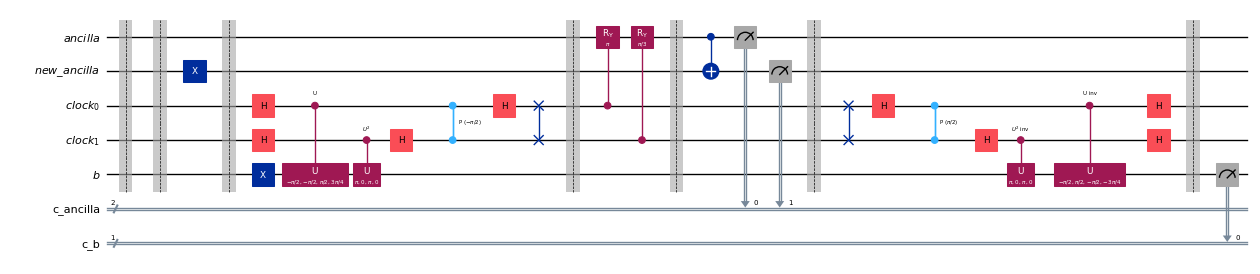

In [7]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot()
height = 0.8
# ax.text(0.5, height, 'Higher energy', size=8)
# ax.text(4.5, height, 'QPE', size=8)
# ax.text(10, height, 'Inverse QFT', size=8)
# ax.text(14, height, 'Controlled Rotation', size=8)
# ax.text(4, -5.5, 'QFT', size=8)
# ax.text(10, -5.5, 'Inverse QPE', size=8)
hhl.draw('mpl', ax=ax, fold=1)